# VacationPy
----

### Part 1
* Create a heat map that displays the humidity for every city from the VacationPy results.

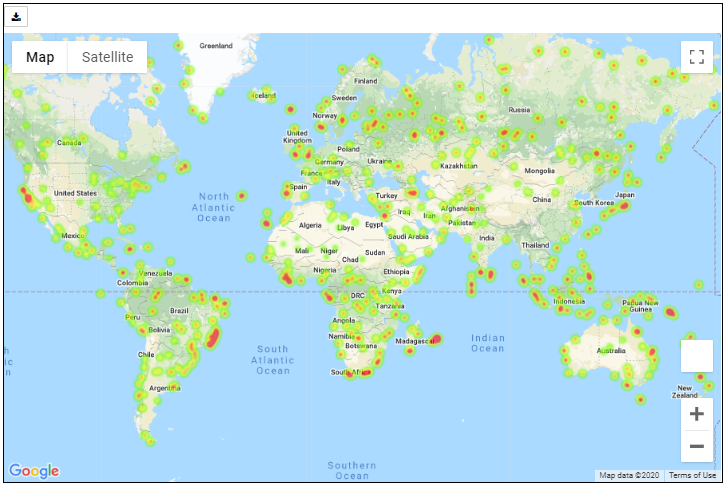

### Part 2
* Narrow down the DataFrame to find your ideal weather condition. For example:
  * Cloudiness less than 20% 
  * Humidity between 25-75%
  * Max temperature netween 60 to 80 
  * Wind speed less than 10 mph

* Drop any rows that don't contain all three conditions. You want to be sure the weather is ideal.

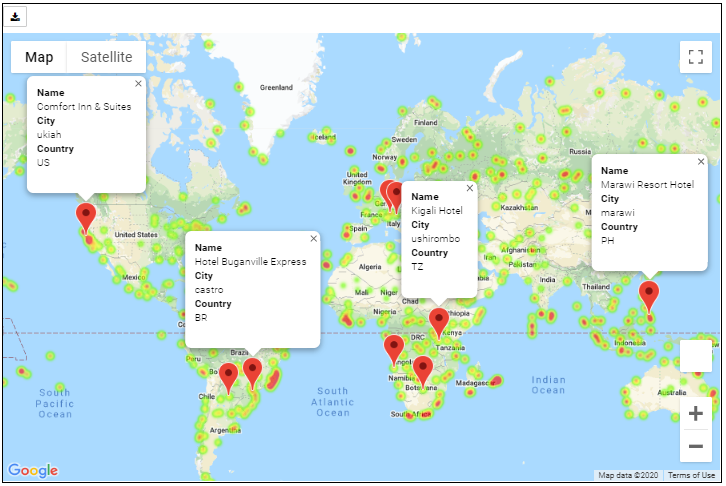


In [7]:
#Import dependencies and API keys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import csv
import os
import json

In [8]:
#Check if google API is loaded successfully from environment variable
if len(g_key)>0:
    print("Weather API key loaded successfully")
else:
    print("Please check if API key is set into environment variable before executing the rest of the code")

Weather API key loaded successfully


### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [9]:
#import csv from WeatherPy
csv_path=os.path.join("..","output_data","cities_data_all.csv")
city_weather = pd.read_csv(csv_path)
city_weather.head(2)

,Unnamed: 0,City,Country,Date,Cloudiness,Humidity,Latitude,Longitude,Max Temp,Wind Speed
0,0,atuona,PF,1586640665,64,68,-9.80,-139.03,82.8,7.47
1,1,rio cuarto,AR,1586640944,45,46,-33.13,-64.35,73.4,16.11


### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [10]:
#Locations - use Lat and Lng
locations = city_weather[["Latitude", "Longitude"]] 

#Use Humidity as weight
weights =city_weather["Humidity"]

#Configure gmpas
gmaps.configure(api_key=g_key)

In [11]:
#Config map size
map_size = {
    'width': '900px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}

#Use zoom_level of 2 and a center point so the map displays properly
fig = gmaps.figure(layout=map_size,zoom_level=2,center=(15,25))

#Create heat layer 
heatmap_layer = gmaps.heatmap_layer(locations, weights=weights,
                                    dissipating=False,
                                    max_intensity=100,
                                    point_radius=2)


#Add layer
fig.add_layer(heatmap_layer)

#Display figure
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [12]:
#Copy data frame
city_hotels = city_weather.copy()
city_weather.shape

(551, 10)

In [13]:
#Max and Min Cloudiness
max_cloudiness= city_hotels["Cloudiness"].max()
min_cloudiness= city_hotels["Cloudiness"].min()
print("Max and Min cloudiness values:",max_cloudiness,min_cloudiness)

Max and Min cloudiness values: 100 0


In [14]:
#Max and Min Humidity
max_humidity= city_hotels["Humidity"].max()
min_humidity= city_hotels["Humidity"].min()
print("Max and Min humidity values:",max_humidity,min_humidity)

Max and Min humidity values: 100 7


In [15]:
#Max and Min of Max Temperature
max_temp= city_hotels["Max Temp"].max()
min_temp= city_hotels["Max Temp"].min()
print("Max and Min temperature values:",max_temp,min_temp)

Max and Min temperature values: 100.9 -5.8


In [16]:
#Max and Min Wind Speed
max_wind_speed= city_hotels["Wind Speed"].max()
min_wind_speed= city_hotels["Wind Speed"].min()
print("Max and Min temperature values:",max_wind_speed,min_wind_speed)

Max and Min temperature values: 39.15 0.45


In [21]:
#Let's decide criteria to narrow down results
# Cloudiness less than 20% 
# Humidity between 25-75%
# Max temperature netween 60 to 80 
# Wind speed less than 10 mph.
# Filter any rows that don't contain all four conditions 

cloudiness = city_hotels["Cloudiness"] <20
humidity = (city_hotels["Humidity"] >=25) &(city_hotels["Humidity"] <=75)
max_temp = (city_hotels["Max Temp"] >=60) & (city_hotels["Max Temp"] <=80)
wind_speed = city_hotels["Wind Speed"] < 10

# new_types_df[max_temp & wind_speed & cludiness]
city_hotels=city_hotels[cloudiness & humidity & max_temp & wind_speed]
city_hotels.head(5)

,Unnamed: 0,City,Country,Date,Cloudiness,Humidity,Latitude,Longitude,Max Temp,Wind Speed
18,18,chepareria,KE,1586640961,16,39,1.31,35.20,65.10,2.06
33,33,ukiah,US,1586640781,1,56,39.15,-123.21,70.00,4.90
43,43,castro,BR,1586640673,13,66,-24.79,-50.01,60.94,2.33
58,58,marawi,PH,1586640965,17,74,8.00,124.29,66.16,2.48
83,83,panay,PH,1586640967,19,72,6.50,124.64,73.02,1.03


In [22]:
#Find City counts
city_hotels.shape

(13, 10)

### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [23]:
#Prepare hotel data frame
hotel_df = pd.DataFrame(city_hotels, columns=["City", "Country", "Latitude", "Longitude"])
#Add hotel name column
hotel_df["Hotel Name"] = ""
#Display sample data set
hotel_df.head()

,City,Country,Latitude,Longitude,Hotel Name
18,chepareria,KE,1.31,35.20,
33,ukiah,US,39.15,-123.21,
43,castro,BR,-24.79,-50.01,
58,marawi,PH,8.00,124.29,
83,panay,PH,6.50,124.64,


In [24]:
#hotel_names list
hotel_name = []

#params dictionary to update each iteration
params = {
    "radius": 5000,
    "types": "hotel",
    "keyword": "hotel",
    "key": g_key
}

# Loop through hotel data frame and get latitude and longitude
for index, row in hotel_df.iterrows():
    # get lat, lng from df
    lat = row["Latitude"]
    lng = row["Longitude"]

    # Add latitude and longitude to params 
    params["location"] = f"{lat},{lng}"

    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    #Prepare request and get response 
    response = requests.get(base_url, params=params)
    
    #Convert response to json format
    response = response.json()
 
    try:
        hotel_name.append(response['results'][0]['name'])
    except IndexError:
        hotel_name.append(np.nan)


In [25]:
# Populate Hotel Name in data frame
hotel_df['Hotel Name']= hotel_name
hotel_df.head()

,City,Country,Latitude,Longitude,Hotel Name
18,chepareria,KE,1.31,35.20,NaN
33,ukiah,US,39.15,-123.21,Comfort Inn & Suites
43,castro,BR,-24.79,-50.01,Hotel Buganville Express
58,marawi,PH,8.00,124.29,Marawi Resort Hotel
83,panay,PH,6.50,124.64,NaN


In [26]:
#Check for null values 
hotel_df.isna().sum()

City          0
Country       0
Latitude      0
Longitude     0
Hotel Name    4
dtype: int64

In [29]:
#Drop those and export clean data to csv file
hotel_df=hotel_df.dropna()

In [30]:
#Check is NA values
hotel_df.isna().sum()

City          0
Country       0
Latitude      0
Longitude     0
Hotel Name    0
dtype: int64

In [31]:
#Display results
hotel_df.head()

,City,Country,Latitude,Longitude,Hotel Name
33,ukiah,US,39.15,-123.21,Comfort Inn & Suites
43,castro,BR,-24.79,-50.01,Hotel Buganville Express
58,marawi,PH,8.00,124.29,Marawi Resort Hotel
157,letlhakeng,BW,-24.09,25.03,Mimshach Investments
244,presidencia roque saenz pena,AR,-26.79,-60.44,Hotel Gualok


In [32]:
#Export to csv file
hotel_csv_path=os.path.join("..","output_data","cities_hotel.csv")
hotel_df.to_csv(hotel_csv_path)

In [35]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Latitude", "Longitude"]]

In [37]:
# Add marker layer ontop of heat map
map_size = {
    'width': '900px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=map_size,zoom_level=2,center=(15,25))

# Create hotel symbol layer
hotel_layer = gmaps.marker_layer(
    locations,info_box_content=[info_box_template.format(**row) for index, row in hotel_df.iterrows()]
)

# Add layer
fig.add_layer(heatmap_layer)
fig.add_layer(hotel_layer)

# Display figure
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…